In [1]:
from bauer.utils.data import load_garcia2022
from bauer.models import MagnitudeComparisonModel
import numpy as np
import pandas as pd
import seaborn as sns
from bauer.utils.plotting import plot_ppc

In [2]:
df = load_garcia2022()

In [4]:
model = MagnitudeComparisonModel(df)

In [5]:
model.build_estimation_model()

{'n1_prior_mu': mean, 'n1_prior_std': std, 'n2_prior_std': std, 'threshold': 0.0, 'n2_prior_mu': AdvancedSubtensor.0, 'n1_evidence_sd': Elemwise{softplus,no_inplace}.0, 'n2_evidence_sd': Elemwise{softplus,no_inplace}.0}


In [6]:
trace = model.sample(draws=1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [n1_evidence_sd_mu_untransformed, n1_evidence_sd_sd, n1_evidence_sd_offset, n2_evidence_sd_mu_untransformed, n2_evidence_sd_sd, n2_evidence_sd_offset, n2_prior_mu_mu, n2_prior_mu_sd, n2_prior_mu_offset]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 77 seconds.


In [7]:
ppc = model.ppc()

Sampling: [ll_bernoulli]


/Users/gdehol/git/bauer/bauer/utils/bayes.py:29: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi = pd.DataFrame(az.hdi(ppc.T.values), index=ppc.index,


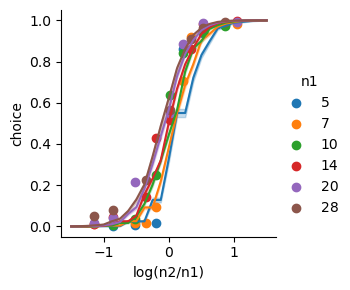

In [8]:
plot_ppc(df, ppc, level='group', plot_type=1)

/Users/gdehol/git/bauer/bauer/utils/bayes.py:29: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi = pd.DataFrame(az.hdi(ppc.T.values), index=ppc.index,
/Users/gdehol/git/bauer/bauer/utils/plotting.py:43: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  p = df.groupby(groupby).mean()[['choice']]


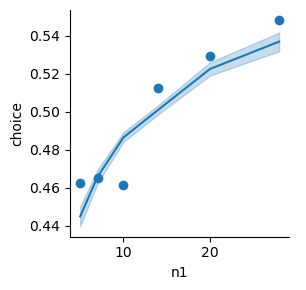

In [9]:
plot_ppc(df, ppc, level='group', plot_type=2)

/Users/gdehol/git/bauer/bauer/utils/bayes.py:29: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi = pd.DataFrame(az.hdi(ppc.T.values), index=ppc.index,


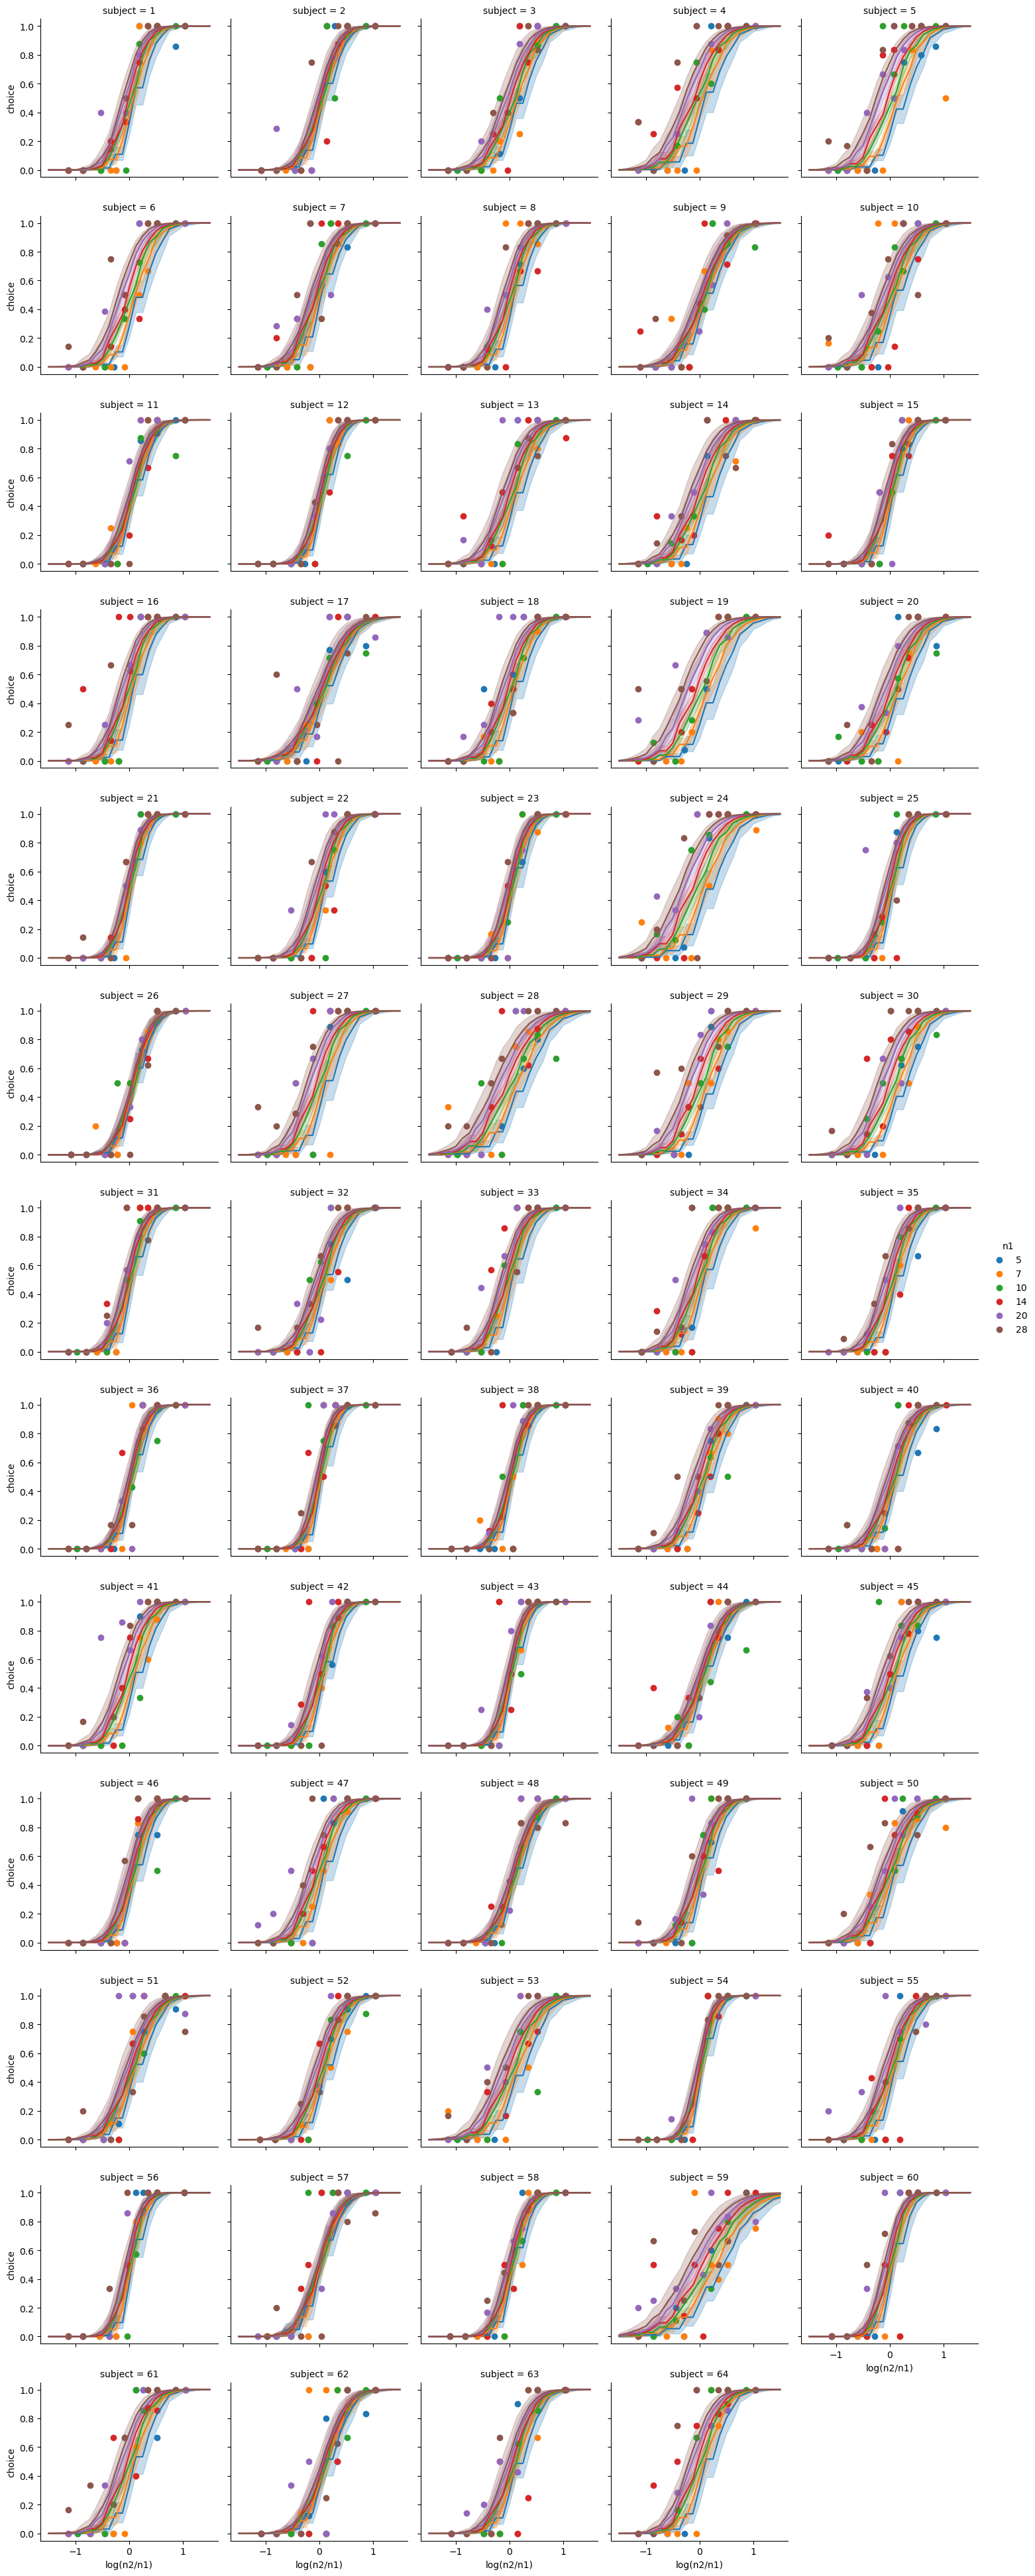

In [10]:
plot_ppc(df, ppc, level='subject', plot_type=1, var_name='p')

/Users/gdehol/git/bauer/bauer/utils/bayes.py:29: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi = pd.DataFrame(az.hdi(ppc.T.values), index=ppc.index,


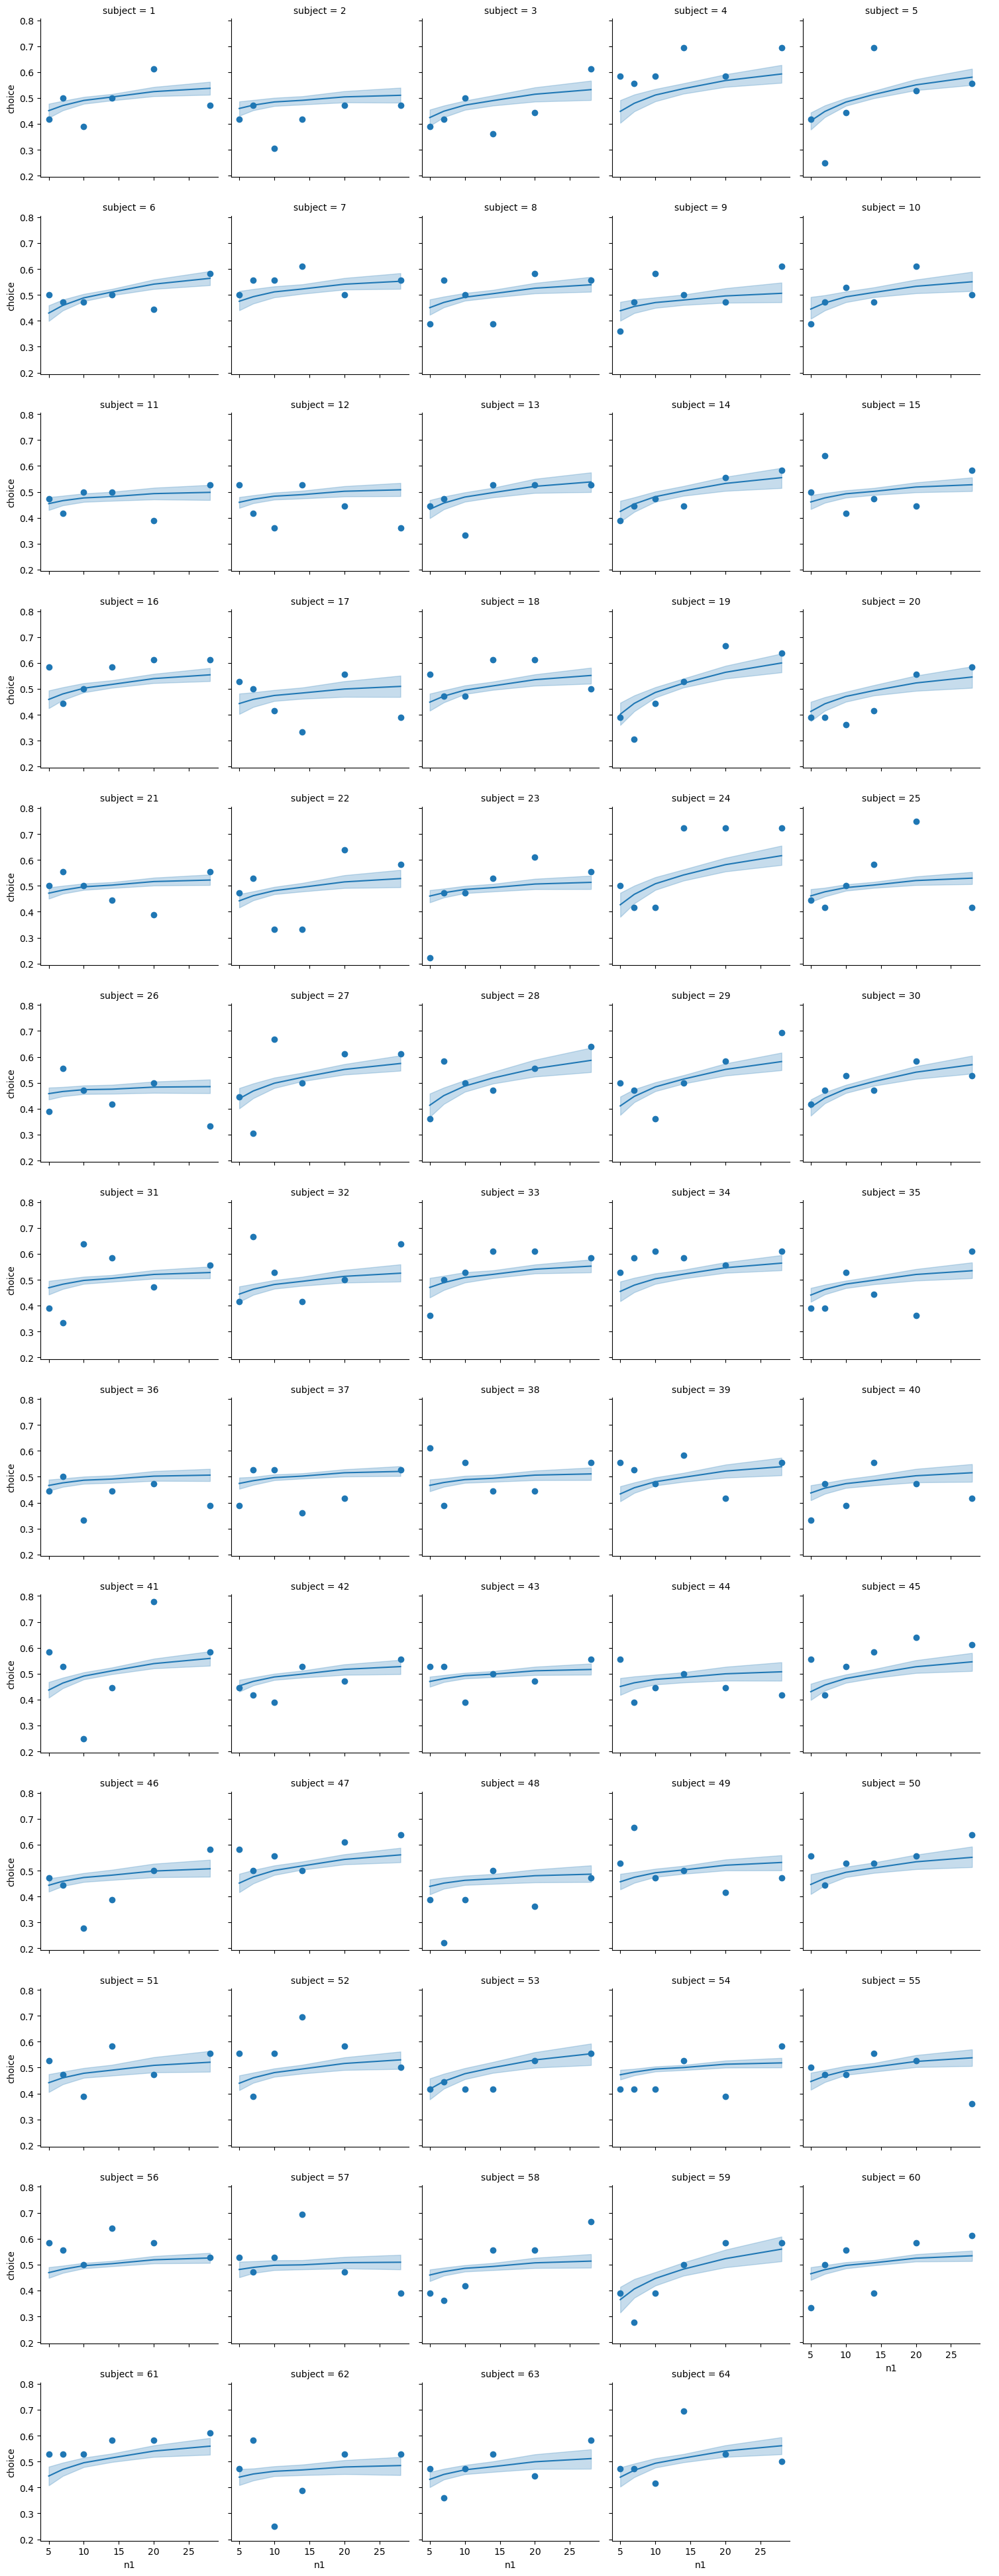

In [11]:
plot_ppc(df, ppc, level='subject', plot_type=2, var_name='p')

In [12]:
import arviz as az
import matplotlib.pyplot as plt

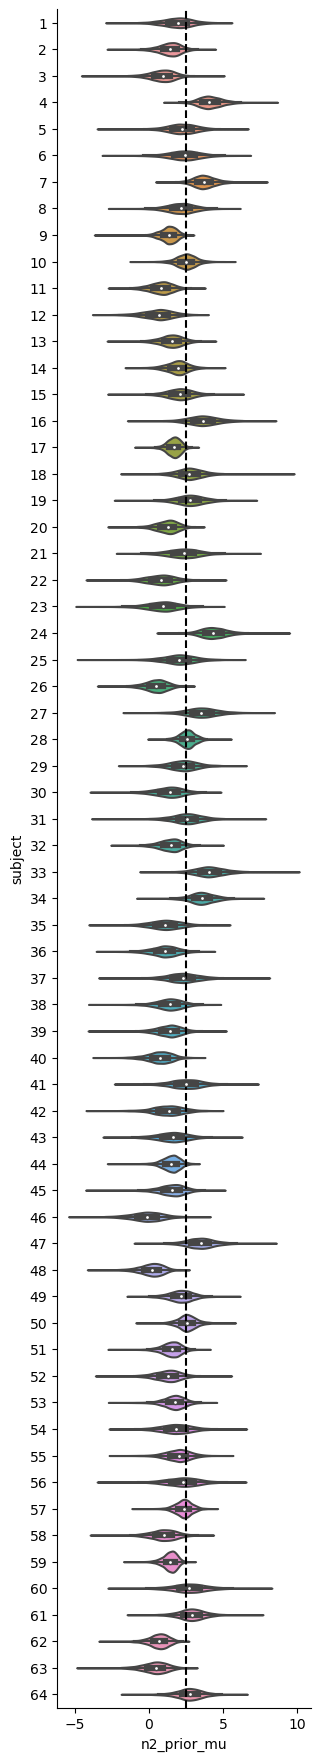

In [13]:
n2_prior_mu = trace.posterior['n2_prior_mu'].to_dataframe()#.reset_index()
n2_prior_mu = n2_prior_mu.reset_index()
n2_prior_mu['subject'] = pd.Categorical(n2_prior_mu['subject'])
fac = sns.catplot(y='subject', x='n2_prior_mu', data=n2_prior_mu.reset_index(), kind='violin')
plt.axvline(np.log(df['n2']).mean(), c='k', ls='--')

fac.fig.set_size_inches(3., 20)

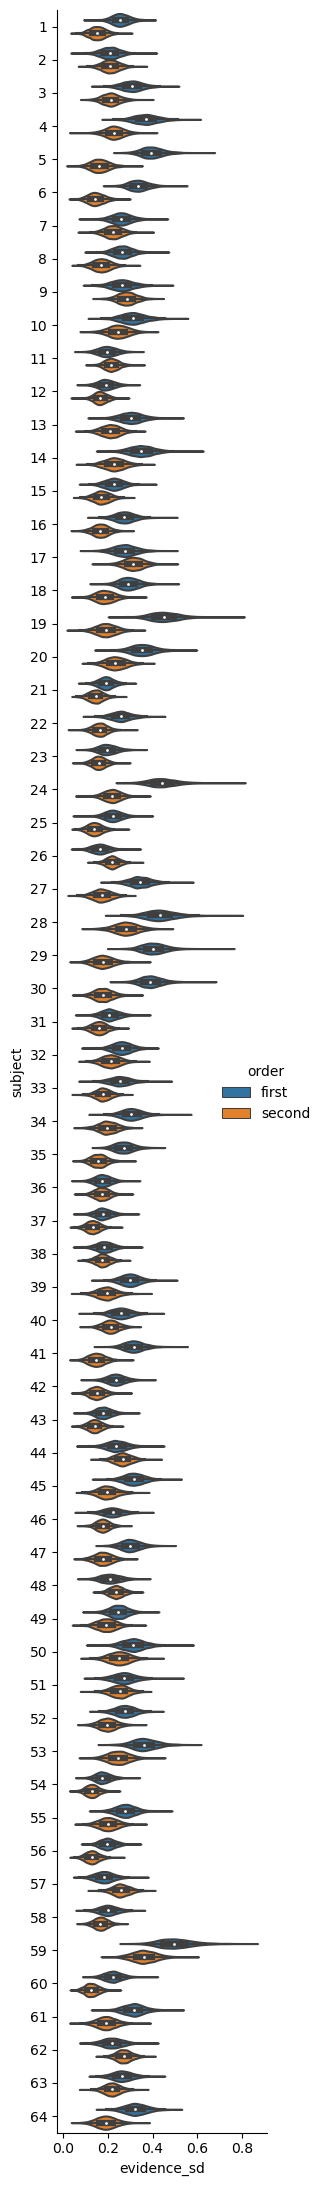

In [14]:
evidence_sd1 = trace.posterior['n1_evidence_sd'].to_dataframe()
evidence_sd2 = trace.posterior['n2_evidence_sd'].to_dataframe()

# evidence_sd = evidence_sd1.join(evidence_sd2)
evidence_sd = pd.concat((evidence_sd1['n1_evidence_sd'], evidence_sd2['n2_evidence_sd']),
keys=['first', 'second'], names=['order'], axis=0).to_frame('evidence_sd')

index_names = evidence_sd.index.names
evidence_sd.reset_index(inplace=True)
evidence_sd['subject'] = pd.Categorical(evidence_sd['subject'])
evidence_sd.set_index(keys=index_names, inplace=True)

fac = sns.catplot(x='evidence_sd', hue='order', y='subject', data=evidence_sd.reset_index(), kind='violin')

fac.fig.set_size_inches(3., 25.)

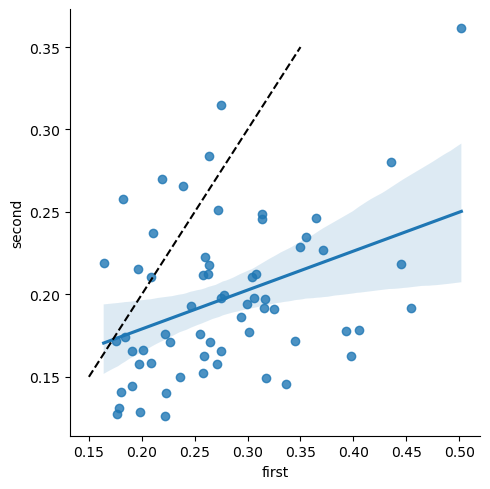

In [15]:
# evidence_sd = trace.posterior['evidence_sd'].to_dataframe()
sns.lmplot(x='first', y='second', data=evidence_sd.unstack('order')['evidence_sd'].groupby(['subject']).mean())
plt.plot([.15, .35], [.15, .35], c='k', ls='--')

In [16]:
import pingouin
pingouin.corr(*evidence_sd.unstack('order')['evidence_sd'].groupby(['subject']).mean().values.T)

,n,r,CI95%,p-val,BF10,power
pearson,64,0.385877,"[0.15, 0.58]",0.001638,19.876,0.892549


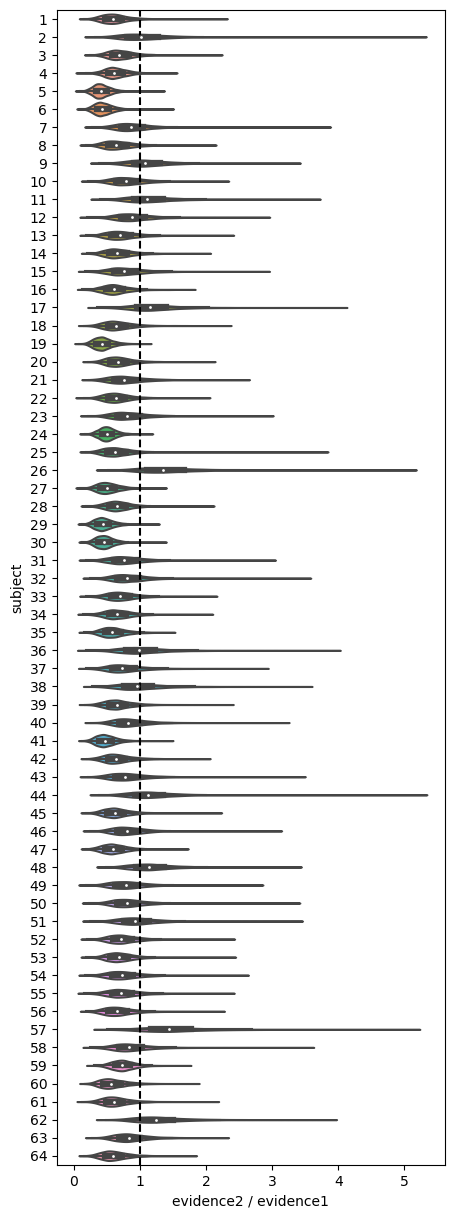

In [17]:
tmp = evidence_sd.unstack('order').droplevel(0, 1)

tmp = (tmp['second'] / tmp['first']).to_frame('evidence2 / evidence1').reset_index()
tmp['subject'] = pd.Categorical(tmp['subject'])

fac = sns.violinplot(data=tmp, x='evidence2 / evidence1', y='subject', kind='violin', aspect=3)
fac.figure.set_size_inches(5, 15)

plt.axvline(1.0, c='k', ls='--')